# Medical-ML

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.under_sampling import NearMiss
from scipy.stats import spearmanr
from scipy.stats.contingency import association
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
np.random.seed(735)
sns.set_theme(style='whitegrid')

In [3]:
# An improvement upon KNNImputer found in sklearn.
class BetterKNNImputer(KNNImputer):
    def __init__(self, numerical_cols: list, categorical_cols: list,
                 target_col: str, is_target_numeric=True):
        self.numerical_cols = [col for col in numerical_cols if col != target_col]
        self.categorical_cols = [col for col in categorical_cols if col != target_col]
        self.target_col = target_col
        self.is_target_numeric = is_target_numeric
        
        self.numerical_transformer = StandardScaler()
        self.categorical_transformer = OneHotEncoder(handle_unknown='ignore')
        
        if is_target_numeric:
            self.target_transformer = StandardScaler()
            self.undersampler = None
        else:
            self.target_transformer = OneHotEncoder(handle_unknown='ignore')
            # NearMiss-1 seems to do well here.
            self.undersampler = NearMiss(version=1, n_neighbors=3)
            
        super().__init__()
        self.weights = 'distance'

    def _preprocess_data_fit(
        self, X: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, np.ndarray, np.ndarray]:
        # Extract the column of interest from X.
        target = X[[self.target_col]].copy()
        X = X.drop(self.target_col, axis=1)
        
        # Standardize numerical columns.
        X[self.numerical_cols] = \
        self.numerical_transformer.fit_transform(X[self.numerical_cols])
        
        # Perform One Hot Encoding on categorical variables.
        categorical_dummies = \
        self.categorical_transformer.fit_transform(X[self.categorical_cols])
        categorical_features = self.categorical_transformer.get_feature_names_out()
        categorical_dummies = \
        pd.DataFrame(data=categorical_dummies.toarray(),
                     columns=categorical_features)
        categorical_features = \
        [col for col in categorical_features if not col.endswith('nan')]
        categorical_dummies = categorical_dummies[categorical_features]
        
        # Concat X so everything in it is encoded.
        X = X.drop(self.categorical_cols, axis=1)
        X = pd.concat([X.reset_index(drop=True), categorical_dummies], axis=1)

        # Perform undersampling if target variable is categorical.
        X_mask = ~X.isna().any(axis=1).to_numpy()
        old_target_mask = ~target.isna().any(axis=1).to_numpy()
        X_target_mask = X_mask & old_target_mask
        if not self.is_target_numeric:
            X_undersampled, target_undersampled = \
            self.undersampler.fit_resample(X[X_target_mask], target[X_target_mask])
            X = pd.concat([X[~X_target_mask], X_undersampled])
            target = pd.concat([target[~X_target_mask], target_undersampled])

        # Make sure index for X isn't nonsense.
        X = X.reset_index(drop=True)

        # Mask is useful for fitting.
        new_target_mask = ~target.isna().any(axis=1).to_numpy()
        # Transform the target variable.
        target = self.target_transformer.fit_transform(target)
        
        return X, target, old_target_mask, new_target_mask

    def _preprocess_data_transform(
        self, X: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, np.ndarray, np.ndarray]:
        # Extract the column of interest from X.
        target = X[[self.target_col]].copy()
        X = X.drop(self.target_col, axis=1)

        # Standardize numerical columns.
        X[self.numerical_cols] = \
        self.numerical_transformer.transform(X[self.numerical_cols])

        # Perform One Hot Encoding on categorical variables.
        categorical_dummies = \
        self.categorical_transformer.transform(X[self.categorical_cols])
        categorical_features = self.categorical_transformer.get_feature_names_out()
        categorical_dummies = \
        pd.DataFrame(data=categorical_dummies.toarray(),
                     columns=categorical_features)
        categorical_features = \
        [col for col in categorical_features if not col.endswith('nan')]
        categorical_dummies = categorical_dummies[categorical_features]

        # Concat X so everything in it is encoded.
        X = X.drop(self.categorical_cols, axis=1)
        X = pd.concat([X.reset_index(drop=True), categorical_dummies], axis=1)

        # Mask is useful for transforming.
        target_mask = ~target.isna().any(axis=1).to_numpy()
        # Transform the target variable.
        target = self.target_transformer.transform(target)
        
        return X, target, target_mask

    def fit(self, X: pd.DataFrame):
        new_data = X.copy()
        X, target, old_target_mask, new_target_mask = self._preprocess_data_fit(X)

        if self.is_target_numeric:
            target = pd.DataFrame(data=target, columns=[self.target_col])
            X = pd.concat([X, target], axis=1)
        else:
            target_features = self.target_transformer.get_feature_names_out()
            target = \
            pd.DataFrame(data=target.toarray(),
                         columns=target_features)
            target_features = \
            [col for col in target_features if not col.endswith('nan')]
            target = target[target_features]
            # Makes it so missing columns are actually read as such.
            target[~new_target_mask] = np.nan
            X = pd.concat([X, target], axis=1)

        # Set n_neighbors using a heuristic.
        self.n_neighbors = int(len(target) ** 0.5)
        
        return super().fit(X)

    def transform(self, X: pd.DataFrame):
        new_data = X.copy()
        X, target, target_mask = self._preprocess_data_transform(X)

        if self.is_target_numeric:
            target = pd.DataFrame(data=target, columns=[self.target_col])
            X = pd.concat([X, target], axis=1)
            new_target = \
            super().transform(X)[:, [-1]]
            new_target = self.target_transformer.inverse_transform(new_target)[:, 0]
            new_data[self.target_col] = new_target
        else:
            target_features = self.target_transformer.get_feature_names_out()
            target = \
            pd.DataFrame(data=target.toarray(),
                         columns=target_features)
            target_features = \
            [col for col in target_features if not col.endswith('nan')]
            target = target[target_features]
            # Makes it so missing columns are actually read as such.
            target[~target_mask] = np.nan
            
            X = pd.concat([X, target], axis=1)
            new_target = \
            super().transform(X)[:, (-len(target_features)):]
            new_target = \
            self.target_transformer.categories_[0][np.argmax(new_target, axis=1)]
            new_data[self.target_col] = new_target
        
        return new_data

def cramerv(var1,var2) :
  crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
  return association(crosstab)

In [4]:
data = pd.read_csv('heart_failure.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
2,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
3,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
4,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0


In [5]:
numeric_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

Let's check if there are any missing values.

In [6]:
display(pd.DataFrame(data.isna().sum(), columns = ['missing']))

,missing
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


There aren't any missing values in the data. It's useful to take a look at summary statistics for numerical columns to see if there are any nonsensical values.

In [7]:
data[numeric_cols].describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,522.000000,522.000000,522.000000,522.000000,522.000000
mean,51.660920,131.197318,216.691571,143.622605,0.591762
std,9.497245,17.357076,88.244897,25.364167,0.899450
min,28.000000,80.000000,0.000000,63.000000,-1.500000
25%,44.000000,120.000000,195.000000,126.250000,0.000000
50%,52.000000,130.000000,226.000000,145.000000,0.000000
75%,58.000000,140.000000,264.000000,162.000000,1.000000
max,76.000000,200.000000,564.000000,202.000000,5.000000


*Age* and *MaxHR* seem to only have reasonable values. Others seem to have a few potential outliers. Let's look at box plots to check if these values are isolated extremes. 

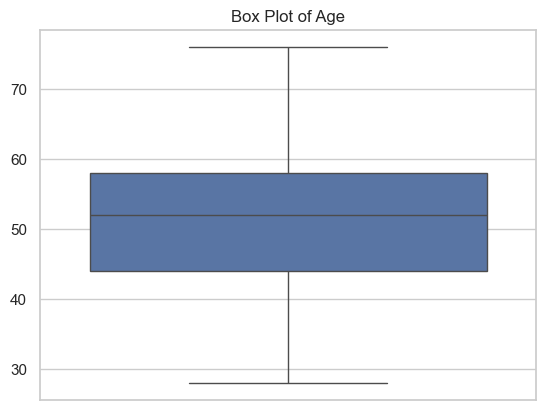

In [8]:
ax = sns.boxplot(data['Age'])
_ = ax.set(title = 'Box Plot of Age', ylabel = None)

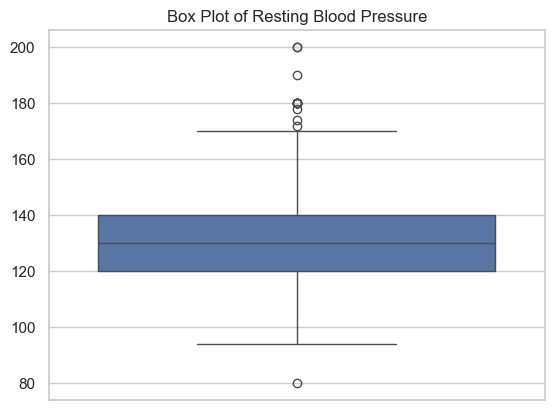

In [9]:
ax = sns.boxplot(data['RestingBP'])
_ = ax.set(title = 'Box Plot of Resting Blood Pressure', ylabel = None)

It seems there are a few extreme values. These are likely not a result of a measurement error, but a fat-tailed distribution. They should be kept in the dataset. 

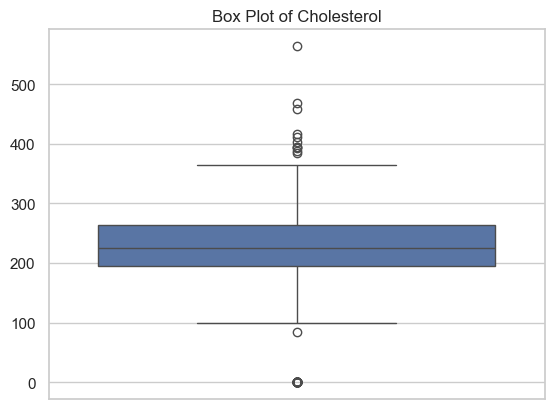

In [10]:
ax = sns.boxplot(data['Cholesterol'])
_ = ax.set(title = 'Box Plot of Cholesterol', ylabel = None)

A few observations here should be removed or their value should be changed to the mean. In particular, a person can't have 0 cholesterol and the value above 500 warrants removal.

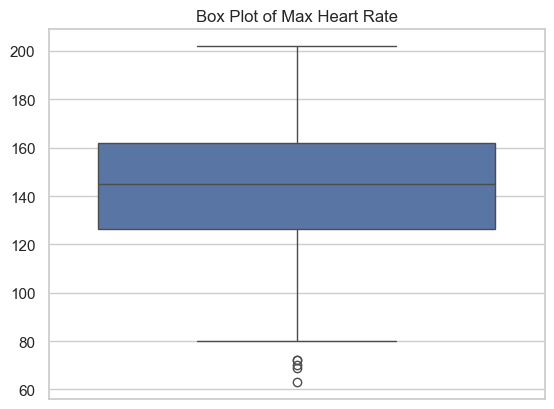

In [11]:
ax = sns.boxplot(data['MaxHR'])
_ = ax.set(title = 'Box Plot of Max Heart Rate', ylabel = None)

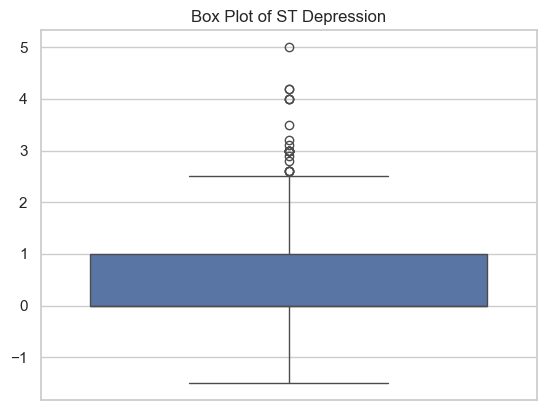

In [12]:
ax = sns.boxplot(data['Oldpeak'])
_ = ax.set(title = 'Box Plot of ST Depression', ylabel = None)

Let's remove the observation with over 500 cholesterol and replace observations with 0 cholesterol through a KNN imputer. 

In [13]:
data = data[data['Cholesterol'] < 500]
data.loc[data['Cholesterol'] == 0, 'Cholesterol'] = np.nan
data['Cholesterol'] = BetterKNNImputer(
    numeric_cols,
    categorical_cols,
    'Cholesterol',
    is_target_numeric=True
).fit_transform(data.drop('HeartDisease', axis=1))['Cholesterol']

Let's verify using the box plot if everything is now okay.

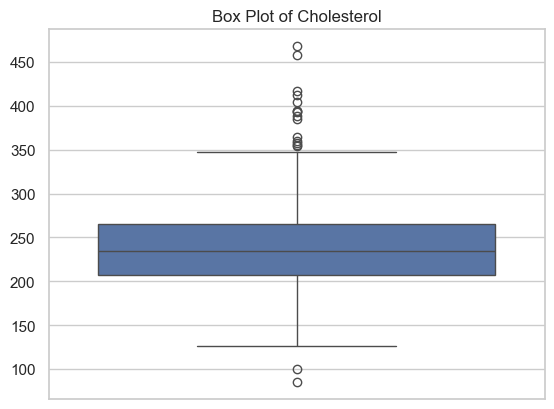

In [14]:
ax = sns.boxplot(data['Cholesterol'])
_ = ax.set(title = 'Box Plot of Cholesterol', ylabel = None)

Everything looks good. Let's see if there is any collinearity in the data.

In [15]:
data[numeric_cols].corr()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
Age,1.000000,0.235697,0.124082,-0.391675,0.249109
RestingBP,0.235697,1.000000,0.132194,-0.109799,0.190216
Cholesterol,0.124082,0.132194,1.000000,-0.026997,0.118896
MaxHR,-0.391675,-0.109799,-0.026997,1.000000,-0.123762
Oldpeak,0.249109,0.190216,0.118896,-0.123762,1.000000


There doesn't seem to be a problem with collinearity. Let's see if there is a monotonic relationship between the numeric variables and the response. We will use Spearman's $\rho$.

In [16]:
numeric_predictive_power = pd.DataFrame(columns = ['rho'])
for col in numeric_cols:
    numeric_predictive_power.loc[col, :] = [spearmanr(data[col], data['HeartDisease']).statistic]
numeric_predictive_power

,rho
Age,0.238759
RestingBP,0.098001
Cholesterol,0.061947
MaxHR,-0.319722
Oldpeak,0.346148


It seems that *RestingBP* and *Cholesterol* may not have that much of an effect on risk of heart disease. We will if that's truly the case when we build models.

Let's now take a look at categorical variables. First it would be good to see if there any extremely rare categories (< 1%).

In [17]:
for col in categorical_cols:
    display(pd.DataFrame(data[col].value_counts(normalize=True)))

,proportion
Sex,
M,0.710173
F,0.289827


,proportion
ChestPainType,
ASY,0.364683
ATA,0.299424
NAP,0.280230
TA,0.055662


,proportion
FastingBS,
0,0.84261
1,0.15739


,proportion
RestingECG,
Normal,0.641075
LVH,0.199616
ST,0.159309


,proportion
ExerciseAngina,
N,0.758157
Y,0.241843


,proportion
ST_Slope,
Up,0.646833
Flat,0.310940
Down,0.042226


The proportions are acceptable.

Let's check if there is dependency between these variables and the response variable. We will check this using Cramer's V.

In [18]:
categorical_predictive_power = pd.DataFrame(columns = ['Cramer_V'])
for col in categorical_cols:
    categorical_predictive_power.loc[col, :] = [cramerv(data[col], data['HeartDisease'])]
categorical_predictive_power

,Cramer_V
Sex,0.241612
ChestPainType,0.442648
FastingBS,0.261378
RestingECG,0.056554
ExerciseAngina,0.479162
ST_Slope,0.517812


Most of these variables seem to have some predictive power, but a possible exception is *RestingECG*. It would also be good to know the class imbalance in the response variable.

In [19]:
print(f'Proportion of people diagnosed with heart disease: {data['HeartDisease'].sum()/ len(data)}')

Proportion of people diagnosed with heart disease: 0.21497120921305182


While the imbalance isn't extreme, it's worth considering during model training. Let's perform the train-test split and verify the resulting datasets are similar.

In [20]:
X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2)

In [21]:
X_train[numeric_cols].describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,416.000000,416.000000,416.000000,416.000000,416.000000
mean,51.877404,131.588942,239.383928,143.394231,0.575240
std,9.498858,17.304690,49.967864,25.410146,0.890533
min,28.000000,80.000000,85.000000,63.000000,-1.500000
25%,45.000000,120.000000,208.000000,128.000000,0.000000
50%,53.000000,130.000000,234.017574,145.000000,0.000000
75%,58.000000,140.000000,263.000000,162.000000,1.000000
max,76.000000,200.000000,468.000000,194.000000,5.000000


In [22]:
X_test[numeric_cols].describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,105.000000,105.000000,105.000000,105.000000,105.000000
mean,50.657143,129.800000,237.477845,144.371429,0.647619
std,9.399088,17.584084,51.490883,25.358301,0.935013
min,29.000000,94.000000,139.000000,80.000000,-0.900000
25%,43.000000,120.000000,201.000000,125.000000,0.000000
50%,52.000000,130.000000,226.000000,144.000000,0.000000
75%,57.000000,140.000000,269.000000,164.000000,1.200000
max,74.000000,180.000000,394.000000,202.000000,4.000000


In [23]:
for col in categorical_cols:
    display(pd.DataFrame(X_train[col].value_counts(normalize=True)))
    display(pd.DataFrame(X_test[col].value_counts(normalize=True)))

,proportion
Sex,
M,0.723558
F,0.276442


,proportion
Sex,
M,0.657143
F,0.342857


,proportion
ChestPainType,
ASY,0.365385
ATA,0.293269
NAP,0.283654
TA,0.057692


,proportion
ChestPainType,
ASY,0.361905
ATA,0.323810
NAP,0.266667
TA,0.047619


,proportion
FastingBS,
0,0.846154
1,0.153846


,proportion
FastingBS,
0,0.828571
1,0.171429


,proportion
RestingECG,
Normal,0.634615
LVH,0.211538
ST,0.153846


,proportion
RestingECG,
Normal,0.666667
ST,0.180952
LVH,0.152381


,proportion
ExerciseAngina,
N,0.762019
Y,0.237981


,proportion
ExerciseAngina,
N,0.742857
Y,0.257143


,proportion
ST_Slope,
Up,0.663462
Flat,0.295673
Down,0.040865


,proportion
ST_Slope,
Up,0.580952
Flat,0.371429
Down,0.047619


In [24]:
print(f'Train proportion: {y_train.sum() / len(y_train)}')
print(f'Test proportion: {y_test.sum() / len(y_test)}')

Train proportion: 0.21153846153846154
Test proportion: 0.22857142857142856


Split seems fairly good. It's time to try building the first few models. We're going to use **DOR** (**Diagnostic Odds Ratio**) for cross-validation. We will test a few potential models:
- logistic regression,
- random forest,
- decision tree boosting,
- SVM.

First we will simply use observation weighting, but afterwards we will also attempt to use undersampling/oversampling.